In [ ]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Linear regression problem is an optimization problem

$$
w = \arg\min \|Y - X^T w\|^2
$$

# HOW TO SOLVE?

$$
w = (X^T X )^{-1}X^T y
$$




But matrix $X$ could be very long and to do all the multiplications directly is insane!

# QR DECOMPOSITION
may help
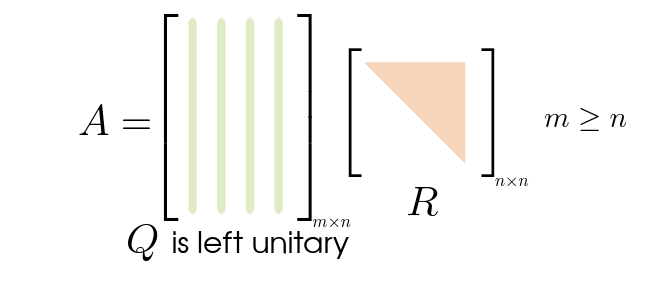

## How does it help?

Let $X = QR$  then

$$
w = (X^T X )^{-1}X^T y = (R^T Q^T Q R )^{-1}R^T Q^T y =  (R^T R )^{-1}R^T Q^T y = ( R )^{-1} Q^T y
$$


## How to get QR decomposition ?  - Gram Schmidt process!




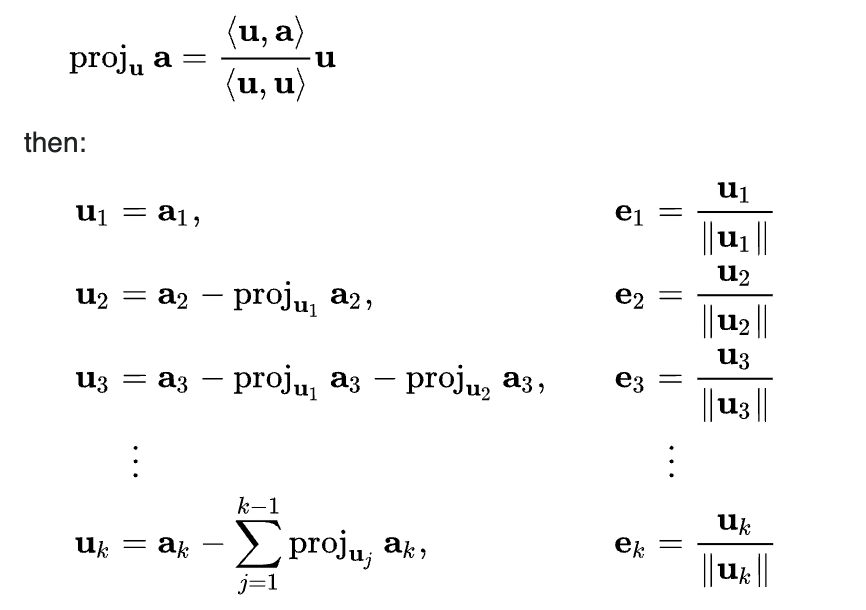

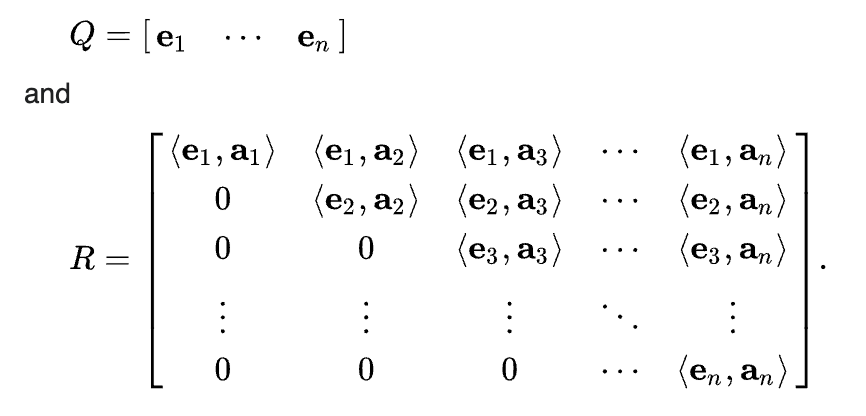

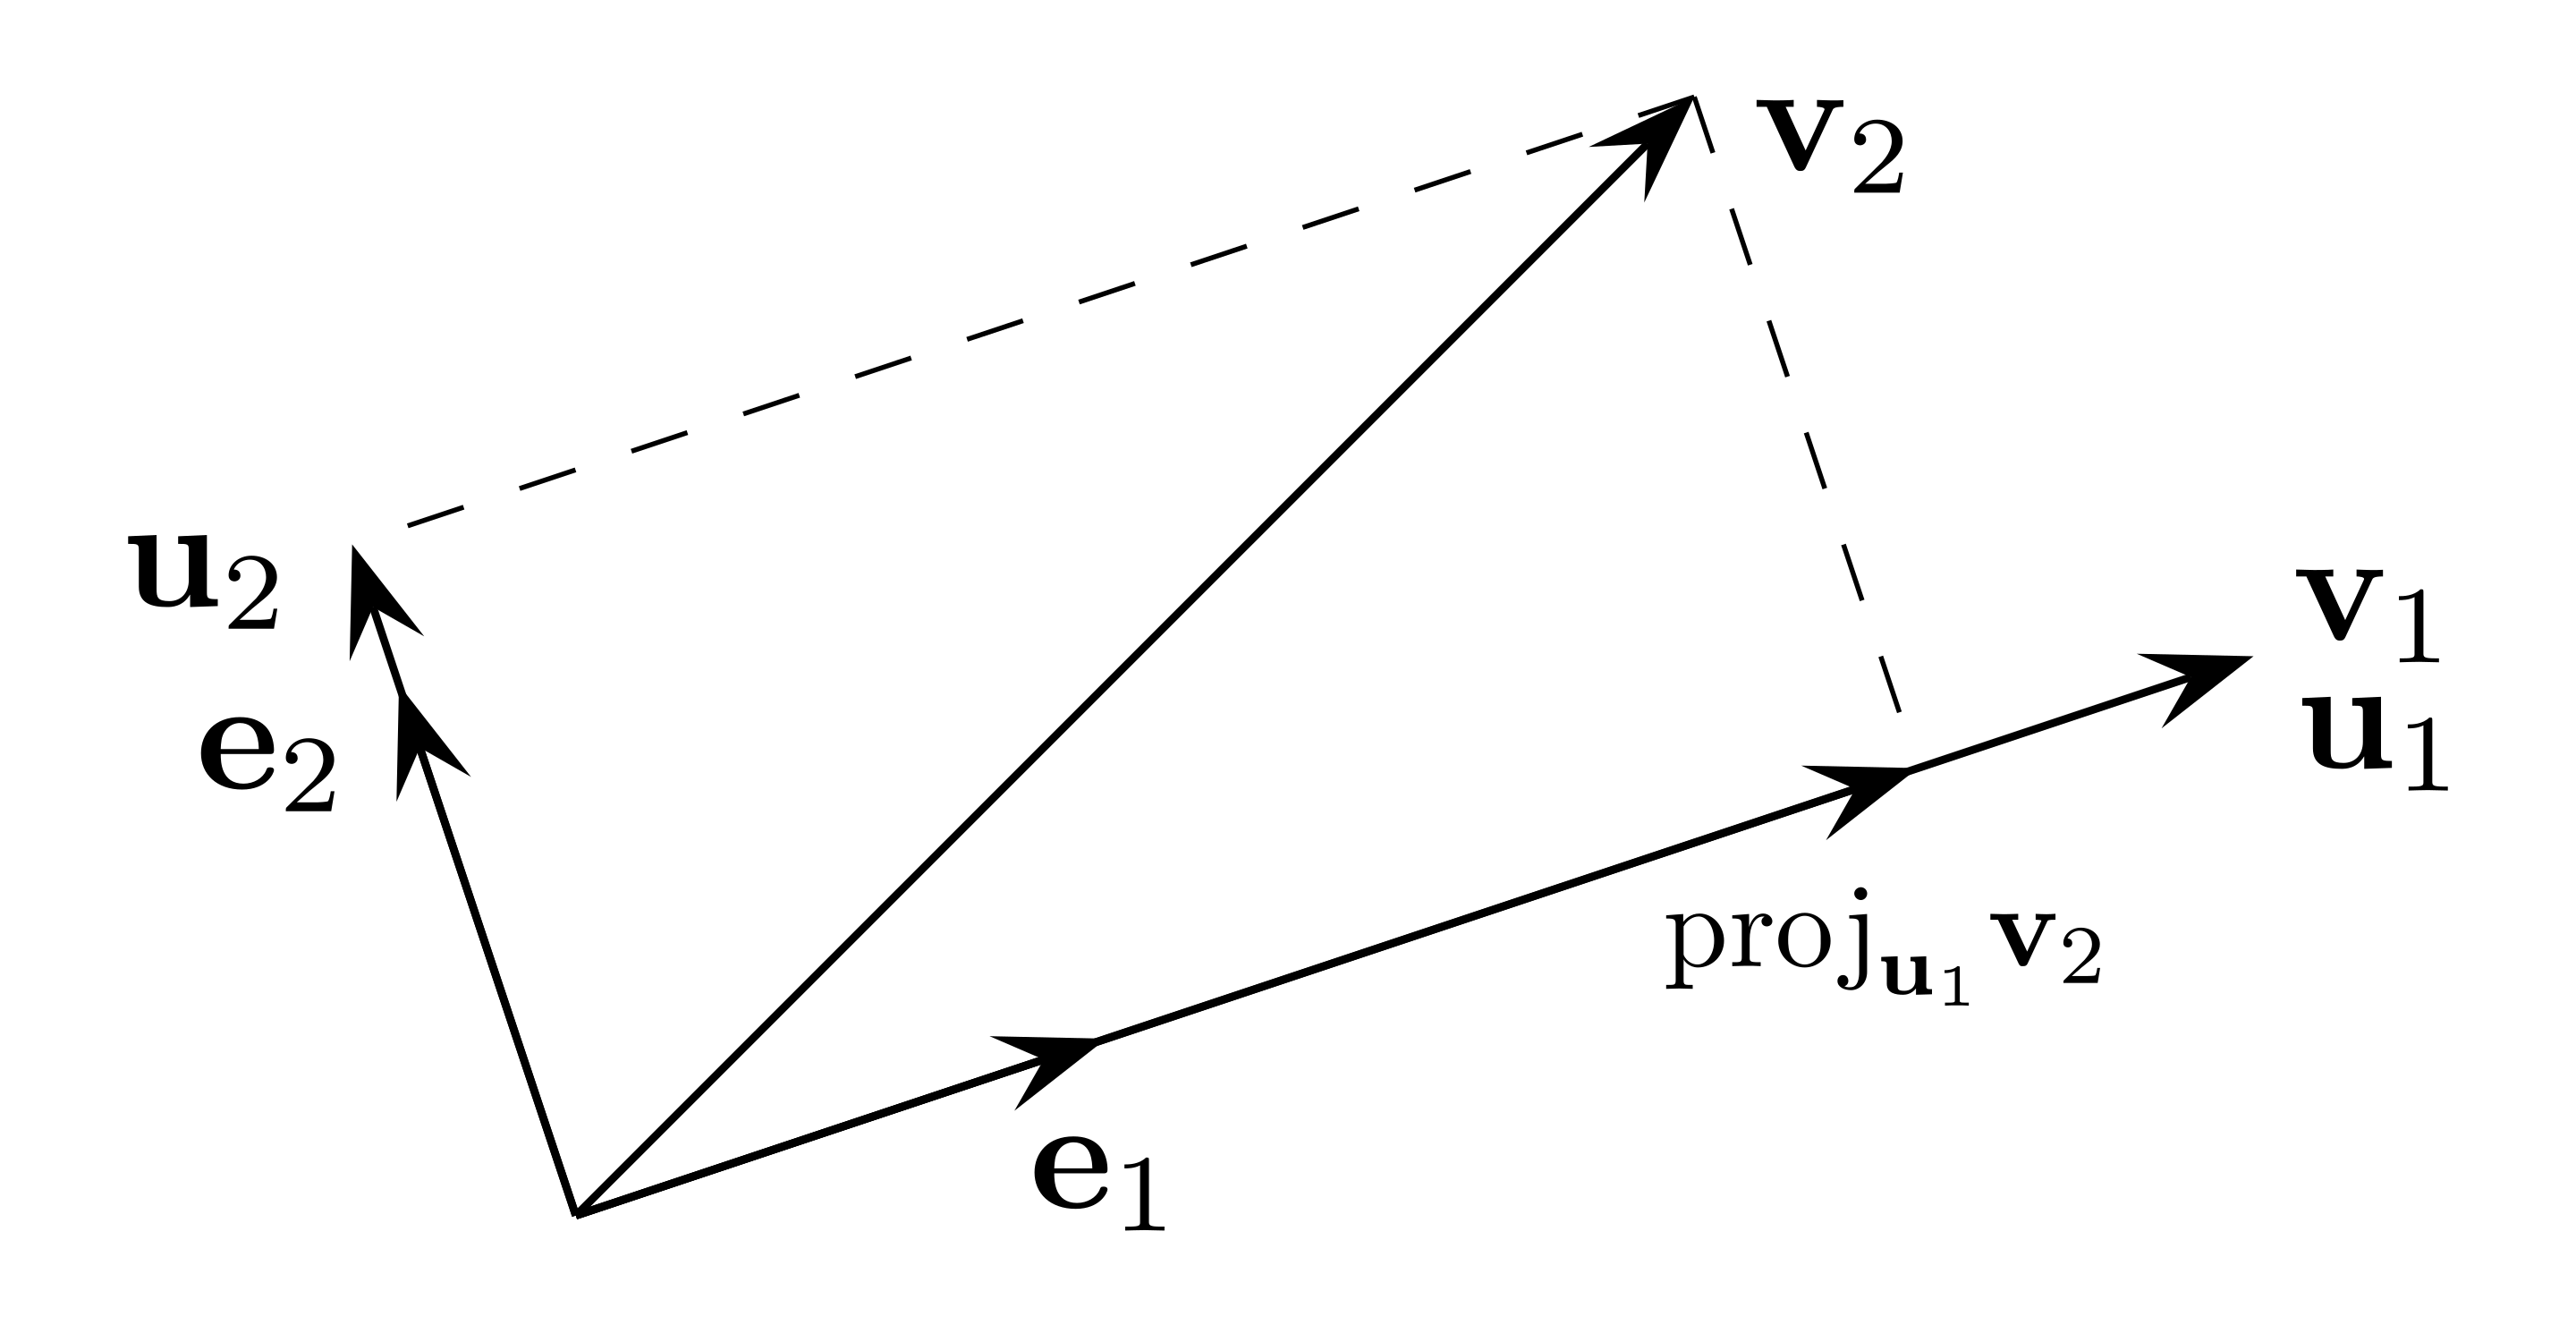

In [ ]:
def proj(u,a):
  return (u @a) * u /( u @ u )

In [ ]:
def QR (A):
  Q = A.copy()
  R = np.zeros(A.shape)
  rows, cols = A.shape
  for col in range(cols):
    a_col = Q[:, col].copy()
    for j in range(col):
      u_j = Q[:, j].copy()
      Q[: ,col] -= proj(u_j, a_col)
    Q[: ,col] /= np.linalg.norm(Q[:, col])
    for row in range(col+1):
      R[row, col] = A[:, col] @ Q[:, row]

  return Q, R[:R.shape[1], :]

In [ ]:
# Sanity check

mat = np.random.rand(600,400)
q, r = QR(mat)

assert np.allclose(np.linalg.norm(q@r - mat),0)

# LET'S GET DOWN TO OUR FIRST LINEAR REGRESSION

## BUT data first

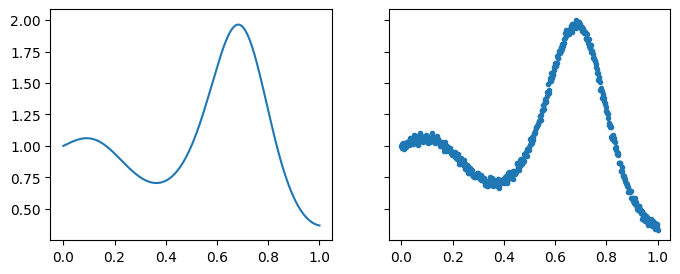

In [ ]:
N_samples = 500
x = np.linspace(0, 1, N_samples)
np.random.seed(4)
y = np.exp(np.cos(3*np.pi*x)*x)
noise = 0.02*np.random.randn(*x.shape)

fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
ax[0].plot(x, y)
ax[1].plot(x, y + noise, ".");

The function we want to predict is nonlinear, obviously. But we have **linear** regression! What is to be done?

The answer is simple: choose features accurately!

**Linear** in linear regression goes for linear dependence on features

In [ ]:
np.random.seed(11)
ind = np.arange(N_samples, dtype=int)
ind_train = np.random.choice(ind, size=(300,), replace=False)
ind_test = np.array(list(set(ind) - set(ind_train)))

x_train, x_test = x[ind_train], x[ind_test]
y_train, y_test = y[ind_train] + noise[ind_train], y[ind_test]

n_poly = 8
f_train = np.stack([x_train**k for k in range(n_poly)], 1)
f_test = np.stack([x_test**k for k in range(n_poly)], 1)

# LETS IMPLEMENT OUR FIRST LINEAR REGRESSION

## NAIVE SOLUTION

$$ w = (X^T X )^{-1}X^T y$$

In [ ]:
np.linalg.pinv(np.array([[1,2], [1,2], [1,2]]))

array([[0.06666667, 0.06666667, 0.06666667],
       [0.13333333, 0.13333333, 0.13333333]])

In [ ]:
class LinearRergession():
    '''LinearRergession with direct solution
    '''
    def __init__(
        self,
        batch_size: int=25,
        lr: float=1e-2,
        num_steps: int=5000,
    ) -> None:

        self.batch_size = batch_size
        self.lr = lr
        self.num_steps = num_steps



    def fit_naive (self, X_train, y_train):


        w = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train
        self.w = w
        return self



    def predict(self, X):
        return X@self.w

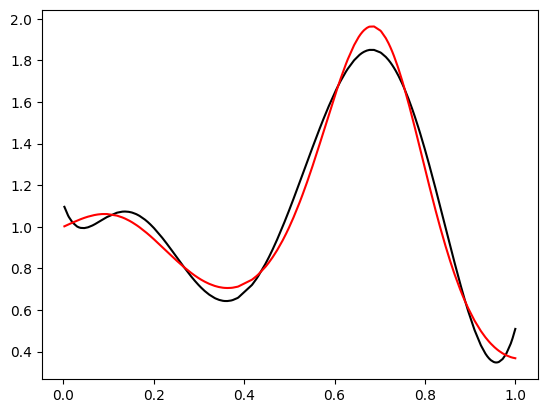

In [ ]:

own_lr = LinearRergession(lr=1e-5, num_steps=50000).fit_naive(f_train, y_train)

y_pred = own_lr.predict(f_test)

plt.plot(x_test, y_pred, color="black")
plt.plot(x_test, y_test, color="red");

## QR SOLUTION

$$
w = ( R )^{-1} Q^T y
$$

In [ ]:
class LinearRergession():
    '''LinearRergession with direct solution
    '''
    def __init__(
        self,
        batch_size: int=25,
        lr: float=1e-2,
        num_steps: int=5000,
    ) -> None:

        self.batch_size = batch_size
        self.lr = lr
        self.num_steps = num_steps



    def fit (self, X_train, y_train):
        q,r = np.linalg.qr(X_train) # QR(X_train)

        w = np.linalg.pinv(r)@q.T@ y_train
        self.w = w
        return self



    def predict(self, X):
        return X@self.w

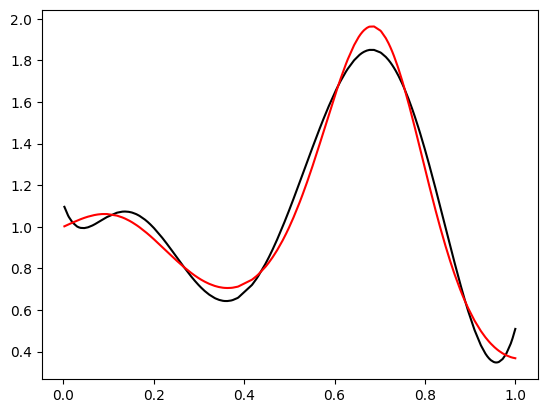

In [ ]:


own_lr = LinearRergession(lr=1e-5, num_steps=50000).fit(f_train, y_train)

y_pred = own_lr.predict(f_test)

plt.plot(x_test, y_pred, color="black")
plt.plot(x_test, y_test, color="red");

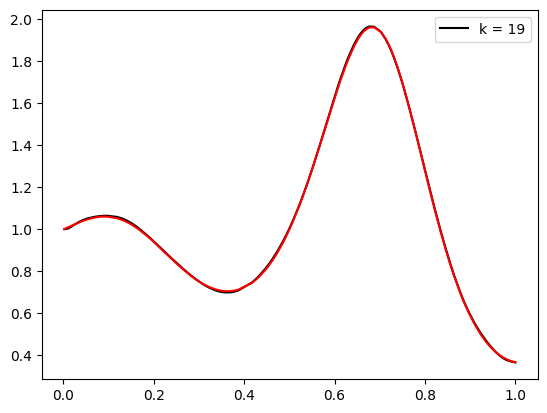

In [ ]:
from IPython.display import clear_output

for n_poly in range(1,20):
    f_train = np.stack([x_train**k for k in range(n_poly)], 1)
    f_test = np.stack([x_test**k for k in range(n_poly)], 1)
    own_lr = LinearRergession(lr=1e-5, num_steps=50000).fit(f_train, y_train)

    y_pred = own_lr.predict(f_test)
    line = 'k = {}'.format(n_poly)
    plt.plot(x_test, y_pred, color="black", label=line)
    plt.plot(x_test, y_test, color="red");

    plt.legend()

    plt.show()
    clear_output(wait=True)

#REGULARIZATION

One way to fix this issue is L2 regularization

$$
w = \arg\min \|Y - X^T w\|^2 + \lambda \|w\|_2^2
$$

Thus our direct solution becomes

$$
w = (X^T X + \lambda I)^{-1}X^T y
$$




In [ ]:
class LinearRergession():
    '''LinearRergession with direct solution
    '''
    def __init__(
        self,
        batch_size: int=25,
        lr: float=1e-2,
        num_steps: int=5000,
        lambd : float=1e-4
    ) -> None:

        self.batch_size = batch_size
        self.lr = lr
        self.num_steps = num_steps
        self.lambd = lambd



    def fit (self, X_train, y_train):
        q,r = QR(X_train)
        w = ...
        self.w = w
        return self




    def fit_reg(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        w = ...
        self.w = w
        return self



    def predict(self, X):
        return X@self.w

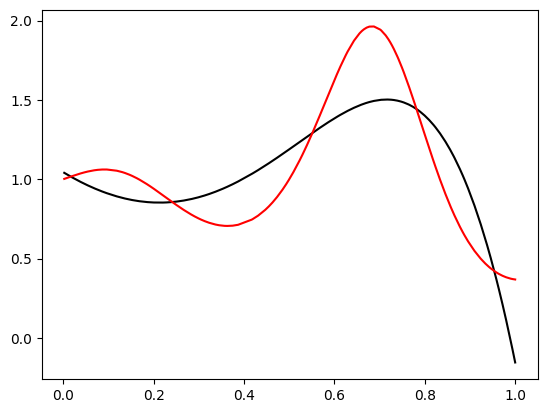

In [ ]:

own_lr = LinearRergession(lr=1e-3, num_steps=5000000).fit_gd_reg(f_train, y_train)

y_pred = own_lr.predict(f_test)

plt.plot(x_test, y_pred, color="black")
plt.plot(x_test, y_test, color="red");

To be honest the main purpose of the l2 regularization is not to let weights become too large. But it also fixes the ill-poseness of the problem

One way to fix this issue is L2 regularization

$$
w = \arg\min \|Y - X^T w\|^2 + \lambda \|w\|^2
$$

Thus our direct solution becomes

$$
w = (X^T X + \lambda I)^{-1}X^T y
$$

$$
X = USV^T
$$
We obtain

$$
w = V(S^2 + \lambda I)^{-1}SU^T y
$$


In [ ]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
import numpy as np
np.expand_dims((1/ np.array([1,3,4])), axis=1)

array([[1.        ],
       [0.33333333],
       [0.25      ]])

In [ ]:
1/ np.array([1,3,4])

array([1.        , 0.33333333, 0.25      ])

In [ ]:
class LinearRergession():
    '''LinearRergession with direct solution
    '''
    def __init__(
        self,
        batch_size: int=25,
        lr: float=1e-2,
        num_steps: int=5000,
        lambd : float=1e-2
    ) -> None:

        self.batch_size = batch_size
        self.lr = lr
        self.num_steps = num_steps
        self.lambd = lambd



    def fit (self, X_train, y_train):
        q,r = QR(X_train)
        # w = np.linalg.solve(r, q.T @ y_train)
        w = np.linalg.pinv(r) @ q.T @ y_train
        self.w = w
        return self

    def fit_reg (self, X_train, y_train):
        u,s,vt = np.linalg.svd(X_train)
        w = np.linalg.pinv(VT) @ np.expand_dims(1/ (S**2+self.lambd), axis=1) @ np.diag(S) @U.T @ y_train
        self.w = w
        return self




    def predict(self, X):
        return X@self.w

In [ ]:
N_samples = 1000
x = np.linspace(0, 1, N_samples)
np.random.seed(4)
y = np.exp(np.cos(3*np.pi*x)*x)
noise = np.random.randn(*x.shape)

ind = np.arange(N_samples, dtype=int)
ind_train = np.random.choice(ind, size=(300,), replace=False)
ind_test = np.array(list(set(ind) - set(ind_train)))

x_train, x_test = x[ind_train], x[ind_test]
y_train, y_test = y[ind_train] + noise[ind_train], y[ind_test]

n_poly = 200
f_train = np.stack([x_train**k for k in range(n_poly)], 1)
f_test = np.stack([x_test**k for k in range(n_poly)], 1)

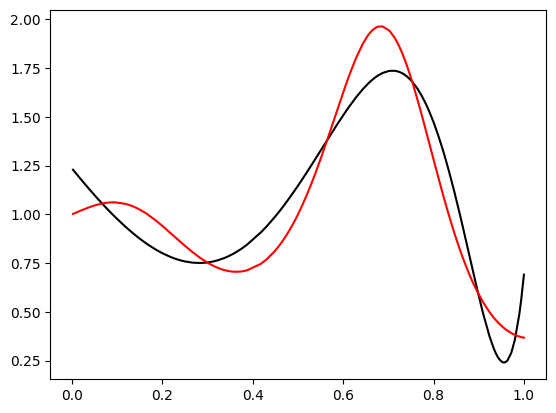

In [ ]:

own_lr = LinearRergession(lr=1e-3, num_steps=500, lambd =1e-2).fit_reg(f_train, y_train)

y_pred = own_lr.predict(f_test)

plt.plot(x_test, y_pred, color="black")
plt.plot(x_test, y_test, color="red");

In [ ]:
np.linalg.cond(f_train.T @ f_train), np.linalg.cond(f_train.T @ f_train  + np.eye(10)* 1e-2 )

(15634986268238.635, 51746.00771764388)

# REAL WORLD  DATA

In [ ]:
california_housing = fetch_california_housing(as_frame=True)

In [ ]:
california_housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


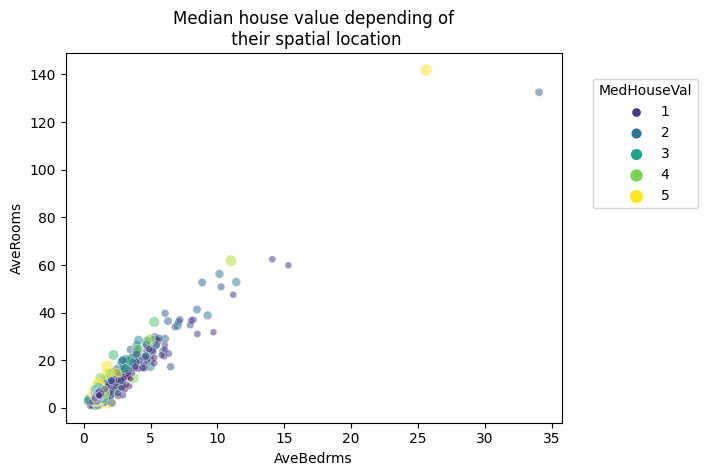

In [ ]:
import seaborn as sns

sns.scatterplot(
    data=california_housing.frame,
    x="AveBedrms",
    y="AveRooms",
    size="MedHouseVal",
    hue="MedHouseVal",
    palette="viridis",
    alpha=0.5,
)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(california_housing.data, california_housing.target)

In [ ]:
scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_scaled = scaler_x.transform(x_train)

scaler_y = StandardScaler()
scaler_y.fit(y_train.values[:, None])
y_scaled = scaler_y.transform(y_train.values[:, None])

In [ ]:
x_scaled_test = scaler_x.transform(x_test)
y_scaled_test= scaler_y.transform(y_test.values[:, None])

In [ ]:
own_lr = LinearRergession().fit(x_scaled, y_scaled[:, 0])

In [ ]:
own_lr.predict(x_scaled)

array([-1.25930274,  0.12033881, -0.0767774 , ..., -0.11725059,
       -0.26230729,  0.25107278])

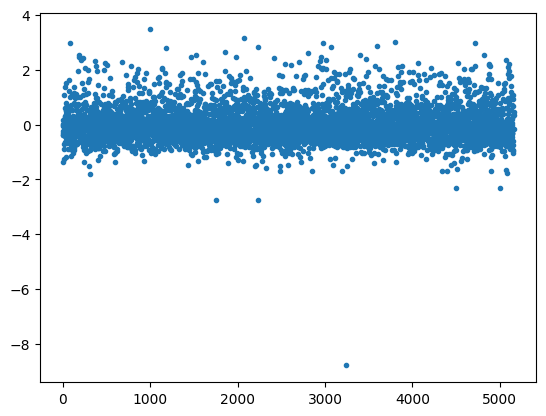

In [ ]:
residual = y_scaled_test.reshape(-1,) - own_lr.predict(x_scaled_test)
np.linalg.norm(residual) / np.linalg.norm(y_scaled_test.reshape(-1,))

plt.plot(residual, ".")

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.200e+01,
        2.110e+03, 2.673e+03, 3.190e+02, 3.300e+01]),
 array([-8.7866508 , -7.56117031, -6.33568981, -5.11020932, -3.88472882,
        -2.65924833, -1.43376784, -0.20828734,  1.01719315,  2.24267365,
         3.46815414]),
 <BarContainer object of 10 artists>)

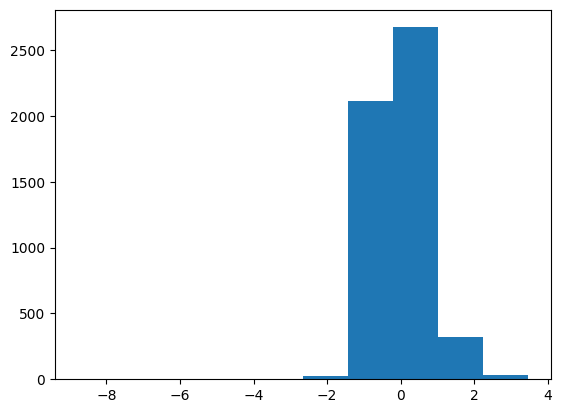

In [ ]:
plt.hist(residual)